# Machine Learning LAB 3: LINEAR REGRESSION

Course 2024/25: *F. Chiariotti*

The notebook contains some simple tasks to be performed with **LINEAR REGRESSION MODELS**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## VR traffic prediction

In this notebook, we will explore the prediction of Virtual Reality (VR) traffic. The data come from the paper:

Lecci, Mattia, _et al._ "An open framework for analyzing and modeling XR network traffic." IEEE Access 9 (2021): 129782-129795.

The VR game Virus Popper was instantiated on a computer through the RiftCat application: the user could then see the virtual content on their phone, which was strapped to their head with a Cardboard viewer. The file virus_popper.csv contains three columns from the traffic capture:
idx    | frame size (B) |  time (s)
0      | 38424          |  0.0
1      | 39801          |  0.01944
...

The game was run at 60 frames per second, with a target rate of 30 Mb/s. The task is then to predict the size of the next frame, given the past N frames. This was explored in another paper:

Chiariotti, Federico, _et al._ "Temporal characterization and prediction of vr traffic: A network slicing use case." IEEE Transactions on Mobile Computing 23.5 (2023): 3890-3908.

---

## Import all the necessary Python libraries

In [12]:
import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    data = data_train.iloc[:, 1].values # Get the second column (frame size) as the input
    return data

# Load the dataset
data = load_dataset('data/virus_popper.csv')

## Prepare the data and create training and test sets

In this case, we are learning a time series: let us consider a memory of 2 samples, i.e., use X[n-1] and X[n-2] to predict X[n].

In [13]:
# Normalize the dataset
avg_size = np.mean(data)
norm_data = np.asarray(data) / avg_size

# Compute the splits and prepare the columns
m_training = int(0.75*norm_data.shape[0])

X_training = np.ones([m_training - 2, 3])
X_training[:,1] = norm_data[: m_training - 2]
X_training[:,2] = norm_data[1 : m_training - 1]
Y_training = norm_data[2 : m_training]


X_test = np.ones([norm_data.shape[0] - m_training - 2, 3])
X_test[:,1] = norm_data[m_training : -2]
X_test[:,2] = norm_data[m_training + 1 : -1]
Y_test = norm_data[m_training + 2:]

print(np.shape(X_training), np.shape(Y_training), np.shape(X_test), np.shape(Y_test))

(25878, 3) (25878,) (8625, 3) (8625,)


## Least Squares linear regression

Train and evaluate the LS regressor on the data

In [14]:
# Least squares solution
def least_squares(X_matrix: np.ndarray, labels: np.ndarray) -> None:
    # Create A matrix by multiplying X by itself
    A = np.transpose(X_matrix).dot(X_matrix)
    # Create b vector by multiplying X by the labels Y
    b = np.transpose(X_matrix).dot(labels)
    # Solve the linear system
    coeff = np.linalg.inv(A).dot(b)
    return coeff

def evaluate_model(x, y, coeff):
    # Linear prediction
    y_pred = x.dot(coeff)
    mse_vector = (y - y_pred) ** 2
    return np.sum(mse_vector) / len(mse_vector)

In [15]:
# Run the LS training and test it on the test data
trained_model = least_squares(X_training, Y_training)
print('Training RMSE:', np.sqrt(evaluate_model(X_training, Y_training, trained_model)) * avg_size)
mse = evaluate_model(X_test, Y_test, trained_model)
print('Model coefficients:', trained_model)
print('Root MSE:', np.sqrt(mse) * avg_size)

Training RMSE: 9070.165039219852
Model coefficients: [0.36986742 0.20348677 0.42565451]
Root MSE: 7712.354721539114


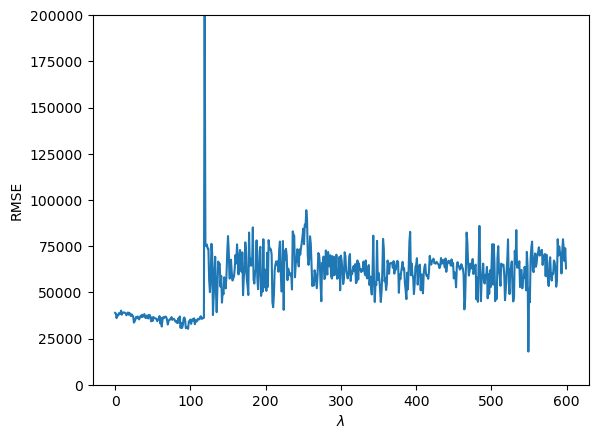

In [16]:
m=600
plt.plot(range(m), Y_training[:m] * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.ylim([0, 200000])
plt.show()

---

## Least Squares with Tikhonov regularization

Perform K-fold cross validation with $\lambda\in\{0, 0.1, 1, 10\}$

In [17]:
# Least squares solution
def regularized_least_squares(X_matrix: np.ndarray, labels: np.ndarray, lambda_par: np.ndarray) -> None:
    # Create A and b as in unregularized LS
    A = np.transpose(X_matrix).dot(X_matrix)
    b = np.transpose(X_matrix).dot(labels)
    # Add the regularization part in the inverse
    coeff = np.linalg.inv(A + lambda_par * np.eye(np.shape(A)[0])).dot(b)
    return coeff

def K_fold(X_training: np.ndarray, Y_training: np.ndarray, lambda_vec: np.ndarray, K: np.ndarray) -> None:
    perm = np.arange(0, np.shape(X_training)[0], 1)
    rnd.shuffle(perm)
    X_shuffled = np.asarray(X_training[perm, :])
    Y_shuffled = np.asarray(Y_training[perm])
    best = -1
    best_perf = 1e20
    results = []
    models = []
    max_idx = np.shape(Y_training)[0]
    # Divide training set in K folds
    fold_points = int(np.floor(max_idx / K))
    for lambda_idx in range(len(lambda_vec)):
        lambda_perf = 0
        for test in range(K):
            x_train_fold = np.concatenate([X_shuffled[: fold_points * test, :], X_shuffled[fold_points * (test + 1) + 1 :, :]])
            y_train_fold = np.concatenate([Y_shuffled[: fold_points * test], Y_shuffled[fold_points * (test + 1) + 1 :]])
            x_validate_fold = X_shuffled[fold_points * test : fold_points * (test + 1) + 1, :]
            y_validate_fold = Y_shuffled[fold_points * test : fold_points * (test + 1) + 1]
            k_model = regularized_least_squares(x_train_fold, y_train_fold, lambda_par[lambda_idx])
            lambda_perf += evaluate_model(x_validate_fold, y_validate_fold, k_model)
        lambda_perf /= K
        results.append(lambda_perf)
        models.append(regularized_least_squares(X_shuffled, Y_shuffled, lambda_par[lambda_idx]))
        if (best_perf > lambda_perf):
            best = regularized_least_squares(X_shuffled, Y_shuffled, lambda_par[lambda_idx])
            best_perf = lambda_perf
    return best, best_perf, models, results

[0.36936616 0.205157   0.42441538] [0.02142896345938071, 0.021428922334825438, 0.021428890551773123, 0.021428867939996932, 0.02142885433257659, 0.02142884956582699, 0.021428853479228526, 0.021428865915359252, 0.02142888671982826, 0.021428915741211176, 0.021428952830987003, 0.02142899784347615, 0.02142905063578056, 0.02142911106772468, 0.02142917900179834, 0.021429254303100262, 0.02142933683928399, 0.021429426480503902, 0.021429523099363322, 0.021429626570863513, 0.021429736772353915, 0.021429853583483528, 0.021429976886153328, 0.02143010656447012, 0.021430242504701123, 0.0214303845952294, 0.02143053272651111, 0.02143068679103282, 0.02143084668327056, 0.021431012299648985, 0.02143118353850238, 0.021431360300035847, 0.021431542486287723, 0.02143173000109262, 0.02143192275004554, 0.021432120640466644, 0.02143232358136662, 0.021432531483413425, 0.021432744258898937, 0.021432961821707164, 0.02143318408728244, 0.02143341097259889, 0.021433642396130208, 0.02143387827782021, 0.0214341185390541

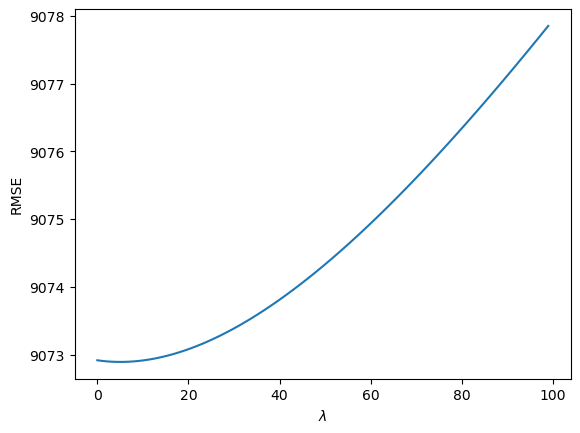

In [21]:
# Run the training with K-fold cross-validation and plot the score
K = 5
lambda_par = range(100)

best_model, best_perf, models, results = K_fold(X_training, Y_training, lambda_par, K)
print(best_model, results)
plt.plot(lambda_par, np.sqrt(results) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


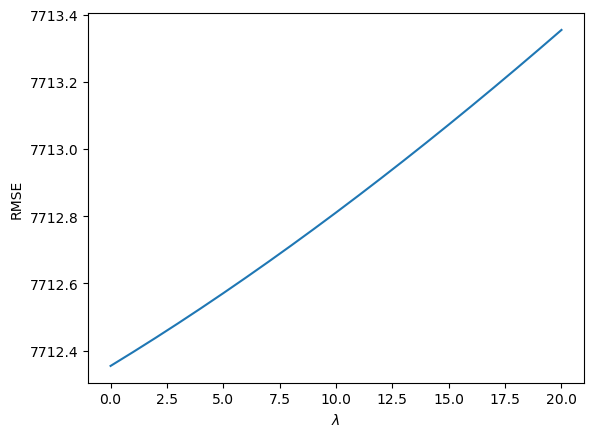

In [19]:
# Plot the results for the regularized models on the test set
test_scores = np.zeros(len(models))

for i in range(len(models)):
    test_scores[i] = evaluate_model(X_test, Y_test, models[i])

plt.plot(lambda_par, np.sqrt(test_scores) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


### EXTRA

Can you figure out the best amount of memory to use?
